## Using CUDA to calculate distances between N points

In [ ]:
def distance(a,b):
    """
    a and b are points to calculate the distance between
    """
    ab_sum=0
    for i in range(len(a)):
        ab_diff = b-a
        ab_diff_sqrd = ab_diff**2
        ab_sum+=ab_diff_sqrd
    ab_dist = ab_sum**.5

def distances(pts):
    np.zeros(len(pts))
    for i in range(len(pts)):
        for j in range(len(pts)):
            if i!=j:
                dist_ij = distance(pts[i],pts[j])

In [1]:
from numba import cuda
import random
import numpy as np

@cuda.jit
def dist_cuda(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    j = tx + bx * bw

    N=len(dx[0])
    #dd[j]=dx[0][j]
    #dd[j]=num
    
    #"""
    for i in range(j+1,N):
        d_ph = 0
        for dim in range(len(dx)):
            d_ph += (dx[dim][j]-dx[dim][i])**2
            
        # this is the distance to point i from point j. A good jumping off point
        # for any other scoring metric...
        dd[i][j]=dd[j][i]=d_ph**.5
    #"""

    
def main():
    # Calculates distances between N points of arbitrary dimensionality.
    
    # pts as array of N points with dim dimensions, n_pts x n_dims
    pts = np.array([[i,j] for i in range(10) for j in range(10)])
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    # Resulting matrix will be n_pts x n_pts
    d = np.array([np.zeros(N) for i in range(N)])
    # Allocate host memory arrays
    
    #d = np.zeros(N*N)

    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(x)
    d_d = cuda.to_device(d)

    threads_per_block = 128
    number_of_blocks = int(N/128)+1 
    
    dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d)

    d_d.copy_to_host(d)
    return d


D = main() # Execute the program

In [5]:
from numba import cuda
import random
import numpy as np

@cuda.jit
def dist_cuda(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i>len(dd):
        return
    d_ph=0
    for dim in range(len(dx)):
        # d_ph is a distance placeholder
        # calculating the distance of all points to the zeroth pt
        d_ph += (dx[dim][i]-dx[dim][0])**2
            
    dd[i]=d_ph**.5
    return

def main():
    # Calculates distances between N points of arbitrary dimensionality.
    
    # pts as array of N points with dim dimensions, n_pts x n_dims
    pts = np.array([[i,j] for i in range(10) for j in range(10)])
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    
    # Allocate host memory arrays
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    d = np.zeros(N)


    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(x)
    d_d = cuda.to_device(d)

    threads_per_block = 128
    number_of_blocks =int(N/128)+1 
    
    dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d)

    d_d.copy_to_host(d)
    return d


D = main() # Execute the program

In [6]:
D

array([  0.        ,   1.        ,   2.        ,   3.        ,
         4.        ,   5.        ,   6.        ,   7.        ,
         8.        ,   9.        ,   1.        ,   1.41421356,
         2.23606798,   3.16227766,   4.12310563,   5.09901951,
         6.08276253,   7.07106781,   8.06225775,   9.05538514,
         2.        ,   2.23606798,   2.82842712,   3.60555128,
         4.47213595,   5.38516481,   6.32455532,   7.28010989,
         8.24621125,   9.21954446,   3.        ,   3.16227766,
         3.60555128,   4.24264069,   5.        ,   5.83095189,
         6.70820393,   7.61577311,   8.54400375,   9.48683298,
         4.        ,   4.12310563,   4.47213595,   5.        ,
         5.65685425,   6.40312424,   7.21110255,   8.06225775,
         8.94427191,   9.8488578 ,   5.        ,   5.09901951,
         5.38516481,   5.83095189,   6.40312424,   7.07106781,
         7.81024968,   8.60232527,   9.43398113,  10.29563014,
         6.        ,   6.08276253,   6.32455532,   6.70

In [34]:
import pandas as pd
import sys
sys.path.append('python')
import clusterOutliers
from numba import cuda
import numpy as np
from datetime import datetime
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

def scale_data(df):
    data = df.iloc[:,0:60]
    scaler = preprocessing.StandardScaler().fit(data)
    scaledData = scaler.transform(data)
    df_scaled = pd.DataFrame(columns=data.columns[0:60],index = data.index,data=scaledData)
    return np.array(df_scaled)

def eps_est(data):
    
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=int(np.ceil(.2*len(data))), algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    # Distance to 2*N/100th instead of 4th because: ... reasons
    neighbors = int(np.ceil(.02*len(data)))
    distArr = distances[:,neighbors]
    distArr.sort()
    pts = range(len(distArr))

    # The following looks for the first instance (past the mid point)
    # where the mean of the following [number] points
    # is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
    # Alternatively, we could consider the variance of the points and draw conclusions from that
    
    if len(data) <= 200:
        number = 10
    else:
        number = 50
    cutoff = 1.05
    for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
            dbEps = distArr[i]
            break

    # Estimating nneighbors by finding the number of pts. 
    # that fall w/in our determined eps for each point.

    count = np.zeros(len(pts))
    for i in pts:    
        for dist in distances[i]:
            if dist <= dbEps:
                count[i]+=1
    average = np.median(count)
    sigma = np.std(count)
    neighbors = average/2 # Divide by 2 for pts on the edges of clusters
    print("""
    Epsilon is in the neighborhood of %s, 
    with an average of %s neighbors within epsilon,
    %s neighbors in half circle (neighbors/2).
    """%(dbEps,average,neighbors))
    return dbEps,neighbors

@cuda.jit
def dist_cuda(dx,dd,dj):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    
    if i>len(dd):
        return

    # d_ph is a distance placeholder
    d_ph=0
    for dim in range(len(dx)):
        d_ph += (dx[dim][i]-dx[dim][dj[0]])**2

    dd[i]=d_ph**.5
    return
    
def distances(pts):
    # Calculates distances between N points of arbitrary dimensionality.
    
    print("Estimating Parameters...")
    # Computationally expensive to calculate, using a sample if too many points
    if len(pts)>10000:
        sample = np.random.random_integers(0,len(pts),10000)
        X_sample = pts[sample]
    else:
        X_sample = pts
        
    dbEps,neighbors= eps_est(X_sample)
    if len(pts)>10000:
        # Scaling neighbors assuming sample is representative
        neighbors = int(neighbors*len(pts)/10000)
        
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    # Resulting matrix will be n_pts x n_pts
    D=[]
    for i in range(10000):
        # Allocate host memory arrays
        d = np.zeros(N)
        j = np.array([i],dtype=np.int)

        # Allocate and copy GPU/device memory
        d_x = cuda.to_device(x)
        d_d = cuda.to_device(d)
        d_j = cuda.to_device(j)

        threads_per_block = 128
        number_of_blocks =N/128+1 

        dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d,d_j)

        d_d.copy_to_host(d)
        d.sort()
        if d[neighbors] > dbEps:
            D.append(-1)
        else:
            D.append(0)
    return D

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q4.dataSample = Q4.data
Q4.filesSample =Q4.dataSample.index
Q4.sampleGenerated = True
Q4.sampleTSNE = True

start = datetime.now()
dataScaled = scale_data(Q4.dataSample)
D = distances(dataScaled) # Execute the program
print(datetime.now()-start)


Estimating Parameters...

    Epsilon is in the neighborhood of 6.91444764188, 
    with an average of 2000.0 neighbors within epsilon,
    1000.0 neighbors in half circle (neighbors/2).
    
0:07:17.968814


In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib import colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
import numpy as np
np.set_printoptions(threshold='nan')
import pandas as pd
import seaborn as sns
import sys
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
sys.path.append('python')
import clusterOutliers
import keplerml

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q4.dataSample = Q4.data
Q4.filesSample =Q4.dataSample.index
Q4.sampleGenerated = True
Q4.sampleTSNE = True

numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.
/home/dgiles/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:107: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib import colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
import numpy as np
np.set_printoptions(threshold='nan')
import pandas as pd
import seaborn as sns
import sys
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
sys.path.append('python')
import clusterOutliers
import keplerml

import pyfits
from numbapro import cuda
from matplotlib.widgets import Slider
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.
/home/dgiles/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:107: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [2]:
featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q8_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles" # path to fits files
Q8 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q11_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q11fitsfiles" # path to fits files
Q11 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q16_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q16fitsfiles" # path to fits files
Q16 = clusterOutliers.clusterOutliers(featCSV,fitsDir)


Q_dict = {'Q8':Q8,'Q4':Q4,'Q11':Q11,'Q16':Q16}
for q in Q_dict:
    Q = Q_dict[q]
    Q.outliers = Q.data

In [4]:
root = Tk.Tk()
root.wm_title("Scatter")

"""--- import light curve data ---"""
Q = Q_dict['Q4']
Qdf = Q.outliers

# data is an array containing each data point
data = np.array(Qdf[['tsne_x','tsne_y']])

# tsneX has all the x-coordinates
tsneX = Qdf.tsne_x
# tsneY has all the y-coordinates
tsneY = Qdf.tsne_y

"""--- Organizing data and Labels ---"""

fig = Figure(figsize=(20,10))

# a tk.DrawingArea
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
# Toolbar to help navigate the data (pan, zoom, save image, etc.)
toolbar = NavigationToolbar2TkAgg(canvas, root)
toolbar.update()
canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)

gs = gridspec.GridSpec(20,6)


def eps_est(data,n):
    
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=int(np.ceil(.1*len(data))), algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    # Distance to 2*N/100th instead of 4th because: ... reasons
    neighbors = n
    distArr = distances[:,neighbors]
    distArr.sort()
    pts = range(len(distArr))

    # The following looks for the first instance (past the mid point)
    # where the mean of the following [number] points
    # is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
    
    number = 5
    cutoff = 1.05
    for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
            dbEps = distArr[i]
            pt=pts[i]
            break
            
    return dbEps

def cluster_and_plot(X_scaled,eps,min_samples):
    ax.cla()
    est = DBSCAN(eps=eps,min_samples=min_samples,n_jobs=-1)
    est.fit(X_scaled)
    clusterLabels = est.labels_

    data_out = Qdf[clusterLabels==-1]
    outX = data_out.tsne_x
    outY = data_out.tsne_y

    # Set those labels
    ax.set_xlabel("Reduced X",fontsize=18)
    ax.set_ylabel("Reduced Y",fontsize=18)
    # Scatter the data
    ax.scatter(Qdf[clusterLabels!=-1].tsne_x,Qdf[clusterLabels!=-1].tsne_y,c=clusterLabels[clusterLabels!=-1],cmap="viridis",alpha=.5)
    ax.scatter(outX,outY,c='red',s=30,alpha=.8)
    ax.annotate("Outliers: %6i"%len(clusterLabels[clusterLabels==-1]),
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.9))
    ax.annotate("Clusters: %6i"%(max(clusterLabels)+1),
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.85))
    ax.annotate("Epsilon: %6.3f"%eps,
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.8))
    ax.annotate("Min Neighbors: %6i"%min_samples,
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.7))
    return

def update_eps(val):
    eps = s_eps.val
    min_samples = int(s_neighbors.val)

    #X = Qdf.iloc[:,0:60]
    #scaler = preprocessing.StandardScaler().fit(X)
    #scaledData = scaler.transform(X)
    #X_scaled = pd.DataFrame(columns=X.columns[0:60],index = X.index,data=scaledData)
    
    X_scaled = Qdf[['tsne_x','tsne_y']]
    cluster_and_plot(X_scaled,eps,min_samples)
    return

    
def update_neighbors(val):
    min_samples = int(s_neighbors.val)
    
    #X = Qdf.iloc[:,0:60]
    #scaler = preprocessing.StandardScaler().fit(X)
    #scaledData = scaler.transform(X)
    #X_scaled = pd.DataFrame(columns=X.columns[0:60],index = X.index,data=scaledData)
    
    X_scaled = Qdf[['tsne_x','tsne_y']]
    # Automatically determines a suggestion for epsilon based on the number of neighbors chosen
    eps = eps_est(X_scaled,min_samples)
    # the following changes eps and initiates update_eps
    s_eps.set_val(eps)
    
    return

# Initial plot
X_scaled = Qdf[['tsne_x','tsne_y']]
min_samples=4
eps = eps_est(X_scaled,min_samples)

with sns.axes_style("white"):
    # empty subplot for scattered data
    ax = fig.add_subplot(gs[0:17,:])

    ax_neighbors = fig.add_subplot(gs[18,:])
    ax_eps = fig.add_subplot(gs[19,:])

    s_neighbors = Slider(ax_neighbors,'Neighbors',1,50,valinit=min_samples,valfmt='%2i')
    s_eps = Slider(ax_eps,'Epsilon',.01,10,valinit=eps,valfmt='%8.3f')
    
cluster_and_plot(X_scaled,eps,min_samples)
    
canvas.draw()
canvas.show()
print("Plotting.")
s_eps.on_changed(update_eps)
s_neighbors.on_changed(update_neighbors)

def _delete_window():
    print("window closed.")
    root.destroy()
    sys.exit()

root.protocol("WM_DELETE_WINDOW",_delete_window)
root.mainloop()

Plotting.
window closed.


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [46]:
Q = Qdict['Q16']
Qdf = Q.outliers
data = Qdf[['tsne_x','tsne_y']]
neighbors = 4

# distance array containing all distances
nbrs = NearestNeighbors(n_neighbors=int(np.ceil(.1*len(data))), algorithm='ball_tree').fit(data)
distances, indices = nbrs.kneighbors(data)
# Distance to 2*N/100th instead of 4th because: ... reasons

distArr = distances[:,neighbors]
distArr.sort()
pts = range(len(distArr))

# The following looks for the first instance (past the mid point)
# where the mean of the following [number] points
# is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
# Alternatively, we could consider the variance of the points and draw conclusions from that

number = 5
    
cutoff = 1.05
for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
    if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
        dbEps = distArr[i]
        pt=pts[i]
        break

plt.scatter(pts,distArr,c='black')
plt.scatter(pt,dbEps,c='red',s=30)
plt.show()

In [77]:
"""
Illustrate the figure and axes enter and leave events by changing the
frame colors on enter and leave
"""
import matplotlib.pyplot as plt

def enter_axes(event):
    print('enter_axes', event.inaxes)
    print(event.inaxes == ax1)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()

fig1 = plt.figure()
fig1.suptitle('mouse hover over figure or axes to trigger events')
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)

fig1.canvas.mpl_connect('figure_enter_event', enter_figure)
fig1.canvas.mpl_connect('figure_leave_event', leave_figure)
fig1.canvas.mpl_connect('axes_enter_event', enter_axes)
fig1.canvas.mpl_connect('axes_leave_event', leave_axes)

fig2 = plt.figure()
fig2.suptitle('mouse hover over figure or axes to trigger events')
ax1 = fig2.add_subplot(211)
ax2 = fig2.add_subplot(212)

fig2.canvas.mpl_connect('figure_enter_event', enter_figure)
fig2.canvas.mpl_connect('figure_leave_event', leave_figure)
fig2.canvas.mpl_connect('axes_enter_event', enter_axes)
fig2.canvas.mpl_connect('axes_leave_event', leave_axes)

plt.show()

('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eaba90>)
False
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eaba90>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)
True
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944c10>)
False
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944c10>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eab990>)
False
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eab990>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)
True
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)


In [44]:
from matplotlib import colors
import matplotlib.cm as cmx
clusterLabels = range(-1,10)
cNorm  = colors.Normalize(vmin=min(clusterLabels),vmax=max(clusterLabels))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')
color = scalarMap.to_rgba(10)
fig = plt.figure()
x=np.arange(100)
y=np.sin(x)
labels = np.zeros_like(x)
labels.fill(4)
plt.scatter(x,y,c=color)
plt.show()

In [30]:
cNorm  = colors.Normalize(vmin=0, vmax=10)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')

In [10]:
from accelerate.cuda import cuda
import random
import numpy as np

@cuda.jit
def dist_cuda(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    j = tx + bx * bw

    N=len(dx[0])
    #dd[j]=dx[0][j]
    #dd[j]=num
    
    #"""
    for i in range(j+1,N):
        d_ph = 0
        for dim in range(len(dx)):
            d_ph += (dx[dim][j]-dx[dim][i])**2
            
        # this is the distance to point i from point j. A good jumping off point
        # for any other scoring metric...
        dd[i][j]=dd[j][i]=d_ph**.5
    #"""

    
def main():
    # Calculates distances between N points of arbitrary dimensionality.
    
    # pts as array of N points with dim dimensions, n_pts x n_dims
    pts = np.array([[i,j] for i in range(10) for j in range(10)])
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    # Resulting matrix will be n_pts x n_pts
    d = np.array([np.zeros(N) for i in range(N)])
    # Allocate host memory arrays
    
    #d = np.zeros(N*N)

    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(x)
    d_d = cuda.to_device(d)

    threads_per_block = 128
    number_of_blocks =N/128+1 
    
    dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d)

    d_d.copy_to_host(d)
    return d


D = main() # Execute the program

In [ ]:
# A GPU application to do DBSCAN
"""
Needs to calculate distance to nth neighbor, and if it's outside of epsilon, it's an outlier.
Otherwise, it's part of a cluster and that cluster needs to be identified.
Clusters could always be identified later... if desired at all...
"""
def calc_nth_neighbor(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    j = tx + bx * bw

    N=len(dx[0])
    #dd[j]=dx[0][j]
    #dd[j]=num
    
    #"""
    for i in range(j+1,N):
        d_ph = 0
        for dim in range(len(dx)):
            d_ph += (dx[dim][j]-dx[dim][i])**2
        if d_ph**.5>cutoff:
            dd=ignore
        # this is the distance to point i from point j. A good jumping off point
        # for any other scoring metric...
        dd[i][j]=dd[j][i]=d_ph**.5
    #"""

In [ ]:
nbrs = NearestNeighbors(n_neighbors=int(max(n,100)), algorithm='ball_tree',n_jobs=-1).fit(data)
distances, indices = nbrs.kneighbors(data)
del nbrs
distArr = distances[:,n]
del distances
for pt in distArr:
    if pt>epsilon:
        clusterLabel=-1
    else:
        clusterLabel=0


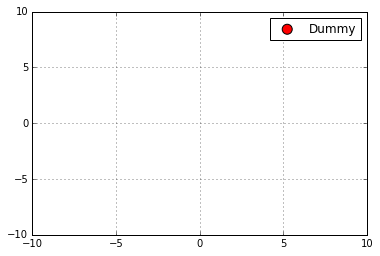

In [233]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
plt.xlim(-10,10)
plt.ylim(-10,10)
ax.scatter([],[],c='red',s=100,label='Dummy')
ax.legend(scatterpoints=1)
plt.grid()
plt.show()

In [106]:
x = np.array([0,1,2,3,1,5,6,2,1])
y = np.zeros_like(x)

z = np.stack([x,y],axis=1)
idx_sort = np.argsort(z,axis=0)[:,0] # sorts based on first number only
z_sorted = z[idx_sort]

u,inv,cts = np.unique(z,axis=0,return_inverse=True,return_counts=True)
u_el=u[cts>1]



[array([4, 8]), array([7])]

In [190]:
x = np.array([0,1,2,3,1,5,6,2,1,5,5,5])
y = np.array([0,2,1,3,1,5,6,2,1,5,30,5])

z = np.stack([x,y],axis=1)
# sorted indexes based on x's, same as np.argsort(x)
idx_sort = np.argsort(z,axis=0)[:,0] 
z_sorted = z[idx_sort]
u,idx,cts = np.unique(z_sorted,axis=0,return_index=True,return_counts=True)
idx = np.sort(idx)
print(idx)
print(z_sorted)
np.split(z_sorted,idx[1:])

[ 0  1  2  4  5  6  7  9 11]
[[ 0  0]
 [ 1  2]
 [ 1  1]
 [ 1  1]
 [ 2  1]
 [ 2  2]
 [ 3  3]
 [ 5  5]
 [ 5  5]
 [ 5 30]
 [ 5  5]
 [ 6  6]]


[array([[0, 0]]), array([[1, 2]]), array([[1, 1],
        [1, 1]]), array([[2, 1]]), array([[2, 2]]), array([[3, 3]]), array([[5, 5],
        [5, 5]]), array([[ 5, 30],
        [ 5,  5]]), array([[6, 6]])]

In [229]:
def duplicates(z):
        x = z[:,0]
        y = z[:,1]
        # sorted indexes based on x's primarily, y secondarily
        idx_sort = np.lexsort((y,x))
        z_sorted = z[idx_sort]
        # unique elements, using z_sorted so the indices are returned in order
        u,idx = np.unique(z_sorted,axis=0,return_index=True)
        # Split sorted indices along unique indices
        idx_split = np.split(idx_sort,idx[1:])
        # Only care about duplicates
        dup_inds = filter(lambda x: x.size > 1,idx_split)
        return dup_inds
    
def label_adjust(x,y,step):
    z = np.stack([x,y],axis=1)
    dup_inds = duplicates(z)
    # making adjustments if there are duplicates
    if dup_inds !=[]:
        i = 1 # Safety net
        while dup_inds!=[]:
            for dup in dup_inds:
                z[dup[1:]]+=[0,step]

            dup_inds = duplicates(z)

            i+=1
            if i>100:
                break
    x=z[:,0]
    y=z[:,1]
    return x,y

x = np.array([0,0,0,0,0,0,0],dtype=np.float)
y = np.array([0,0,0,0,0,0,0],dtype=np.float)
x1,y1 = label_adjust(x,y,0.5)
print(x)
print(x1)
print(y)
print(y1)

[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.   0.5  1.   1.5  2.   2.5  3. ]


In [201]:
x = np.array([0,1,2,3,1,5,6,2,1,5,30,5])
y = np.array([0,2,1,3,1,5,6,2,1,5,5,5])

z = np.stack([x,y],axis=1)
print(z)
ind = np.lexsort((y,x))
z[ind]

[[ 0  0]
 [ 1  2]
 [ 2  1]
 [ 3  3]
 [ 1  1]
 [ 5  5]
 [ 6  6]
 [ 2  2]
 [ 1  1]
 [ 5  5]
 [30  5]
 [ 5  5]]


array([[ 0,  0],
       [ 1,  1],
       [ 1,  1],
       [ 1,  2],
       [ 2,  1],
       [ 2,  2],
       [ 3,  3],
       [ 5,  5],
       [ 5,  5],
       [ 5,  5],
       [ 6,  6],
       [30,  5]])

In [3]:
import numpy as np
import numba
from numba import cuda

In [10]:
@cuda.jit
def dist_cuda(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    j = tx + bx * bw

    N=len(dx[0])
    
    #"""
    for i in range(j+1,N):
        d_ph = 0
        for dim in range(len(dx)):
            d_ph += (dx[dim][j]-dx[dim][i])**2
            
        # this is the distance to point i from point j. A good jumping off point
        # for any other scoring metric...
        dd[i][j]=dd[j][i]=d_ph**.5
    #"""

    
def main(points):
    """
    Calculates distances between N points of arbitrary dimensionality.
    Points as array of N points with dim dimensions, n_pts x n_dims
    """

    N=len(points)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    X = points.T
    # Resulting matrix will be n_pts x n_pts
    d = np.zeros((N,N))
    # Allocate host memory arrays
    
    #d = np.zeros(N*N)

    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(X)
    d_d = cuda.to_device(d)

    threads_per_block = int(128)
    number_of_blocks =int(N/128)+1 
    
    dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d)

    d_d.copy_to_host(d)
    return d
points = np.random.rand(300).reshape(100,3)*100-50
d=main(points)

In [12]:
points = np.random.rand(30).reshape(10,3)*100-50
%timeit main(points)
points = np.random.rand(300).reshape(100,3)*100-50
%timeit main(points)
points = np.random.rand(3000).reshape(1000,3)*100-50
%timeit main(points)

697 µs ± 69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.17 ms ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.9 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
def distance(points):
    N=len(points)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    X = points.T
    # Resulting matrix will be n_pts x n_pts
    d = np.zeros((N,N))
    for i,pt1 in enumerate(points):
        for j,pt2 in enumerate(points[i+1:]):
            if i!=j:
                d[i,j] = d[j,i] = np.sum((pt2-pt1)**2)**.5
    return d

In [16]:
points = np.random.rand(30).reshape(10,3)*100-50
%timeit distance(points)
points = np.random.rand(300).reshape(100,3)*100-50
%timeit distance(points)
points = np.random.rand(3000).reshape(1000,3)*100-50
%timeit distance(points)

481 µs ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
46.8 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.65 s ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
from numba import jit

In [21]:

@jit(nopython=True)
def distance(points):
    N=len(points)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    X = points.T
    # Resulting matrix will be n_pts x n_pts
    d = np.zeros((N,N))
    for i,pt1 in enumerate(points):
        for j,pt2 in enumerate(points[i+1:]):
            if i!=j:
                d[i,j] = d[j,i] = np.sum((pt2-pt1)**2)**.5
    return d

In [1]:
import pickle
import gc
import pandas as pd
import numpy
import os

In [3]:
import pandas as pd

In [1]:
import sys
sys.path.append('python')
import keplerml

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
Q1_fl = '/home/dgiles/Documents/KeplerLCs/filelists/Q1_filelist'
with open(Q1_fl,'r') as file:
    f0 = file.readline()[:-1]

path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q1fitsfiles/'
testfile = path_to_fits+f0

In [3]:
lc = keplerml.import_lcs(testfile)

In [4]:
fts = keplerml.feature_calc(lc)

In [10]:
%%timeit 
lc = keplerml.import_lcs(testfile)
fts = keplerml.feature_calc(lc)

29.6 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
import pickle
Q1 = pickle.load(open('Q1_output.p','rb'))

In [8]:
df = pd.DataFrame(index=[fts[0]],data=[fts[1]],columns=Q1.columns)

In [9]:
pd.set_option('display.max_columns',60)
df.append(Q1.loc[f0])

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,kurt,mad,maxslope,minslope,meanpslope,meannslope,g_asymm,rough_g_asymm,diff_asymm,skewslope,varabsslope,varslope,meanabsslope,absmeansecder,num_pspikes,num_nspikes,num_psdspikes,num_nsdspikes,stdratio,pstrend,num_zcross,num_pm,len_nmax,len_nmin,mautocorrcoef,ptpslopes,periodicity,periodicityr,naiveperiod,maxvars,maxvarsr,oeratio,amp,normamp,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
kplr003543899-2009166043257_llc.fits,0.000001,0.999952,5.035201,1.197313e-07,0.000346,0.000346,1,0,1,389,112.336791,0.00018,0.02001,-0.019124,0.006592,-0.007161,-0.920564,1.080769,-0.000569,0.449978,0.000173,0.00022,0.006866,1.14585,1,1,2,1620,0.981061,0.198398,1,520,82,79,0.132197,0.000021,0.385557,24.096642,0.407427,0.000818,0.025646,1.000002,0.00127,0.00127,0.37069,0.133199,0.235127,0.35737,0.527264,0.782527,0.007125,5.611429,-0.484674,0.615293,0.003275,0.003267,0.005832,-0.005304,-1.099544,1.002373
kplr003543899-2009166043257_llc.fits,0.000001,0.999953,5.035201,1.197309e-07,0.000346,0.000346,1,0,1,389,112.336791,0.00018,0.02001,-0.019124,0.006592,-0.007161,-0.920564,1.080769,-0.000569,0.449978,0.000173,0.00022,0.006866,1.14585,1,1,2,1620,0.981061,0.198398,1,520,82,79,0.132197,0.000021,0.385557,24.096642,0.407427,0.000818,0.025646,1.000002,0.00127,0.00127,0.37069,0.133199,0.235127,0.35737,0.527264,0.782527,0.007125,5.611429,-0.484674,0.615293,0.003275,0.003267,0.005832,-0.005304,-1.099544,1.002373
kplr003543899-2009166043257_llc.fits,0.000001,0.999953,5.035201,1.197309e-07,0.000346,0.000346,1,0,1,389,112.336791,0.00018,0.02001,-0.019124,0.006592,-0.007161,-0.920564,1.080769,-0.000569,0.449978,0.000173,0.00022,0.006866,1.14585,1,1,2,1620,0.981061,0.198398,1,520,82,79,0.132197,0.000021,0.385557,24.096642,0.407427,0.000818,0.025646,1.000002,0.00127,0.00127,0.37069,0.133199,0.235127,0.35737,0.527264,0.782527,0.007125,5.611429,-0.484674,0.615293,0.003275,0.003267,0.005832,-0.005304,-1.099544,1.002373


In [14]:
with open(Q1_fl,'r') as file:
    files = file.readlines()

In [8]:
from datetime import datetime
starttime = datetime.now()
keplerml.features_from_filelist(Q1_fl,path_to_fits,'Q1_output_v2_2.p',fl_as_array=False,verbose=True)
endtime = datetime.now()
print("Processing took {}".format(endtime-starttime))
 

Reading /home/dgiles/Documents/KeplerLCs/filelists/Q1_filelist...
Using 47 cpus to calculate features...
Importing 156126 lightcurves...
Processing 156126 files...


/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


10000/156126 completed
20000/156126 completed
30000/156126 completed
40000/156126 completed
50000/156126 completed
60000/156126 completed
70000/156126 completed
80000/156126 completed
90000/156126 completed
100000/156126 completed
110000/156126 completed
120000/156126 completed
130000/156126 completed
140000/156126 completed
150000/156126 completed
Features have been calculated
Saving output to Q1_output_v2_2.p
Cleaning up...
Done.
Processing took 0:48:44.673014


In [1]:
# Running on 5/02/19
import sys
sys.path.append('python')
import keplerml
from datetime import datetime

starttime = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
feats = keplerml.features_from_filelist(Q_fl,path_to_fits,'Q{}_output_v2_2.p'.format(i),fl_as_array=False,numCpus=16,verbose=True)
del(feats)
endtime = datetime.now()
print("Processing took {}".format(endtime-starttime))

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Reading /home/dgiles/Documents/KeplerLCs/filelists/Q11_filelist...
Using 16 cpus to calculate features...
Importing 164065 lightcurves...
Lightcurve import took 0:03:40.730379
Processing 164065 files...
10000/164065 completed. Time for chunk: 0:02:44.698737
20000/164065 completed. Time for chunk: 0:02:39.923911
30000/164065 completed. Time for chunk: 0:02:34.313444
40000/164065 completed. Time for chunk: 0:02:43.683818
50000/164065 completed. Time for chunk: 0:02:50.531332
60000/164065 completed. Time for chunk: 0:03:04.055427
70000/164065 completed. Time for chunk: 0:02:35.651453
80000/164065 completed. Time for chunk: 0:02:30.451764
90000/164065 completed. Time for chunk: 0:02:45.806087
100000/164065 completed. Time for chunk: 0:03:05.739053
110000/164065 completed. Time for chunk: 0:02:40.522628
120000/164065 completed. Time for chunk: 0:02:37.943154
130000/164065 completed. Time for chunk: 0:02:41.047562
140000/164065 completed. Time for chunk: 0:02:47.953941
150000/164065 complete

In [35]:
"""
All quarters processed using the following script between 5/02/19 and 05/14/19.
Each feature definition has been checked and several were fixed (there were issues with handling data at the ends)
This updated methodology significantly improves compute time for processing a single light curve. 
Parallellization has also been implemented, but the optimal number of cores is not the maximum available, 
but rather about a quarter of the available cores (16 out of 48 in this case). The reason for this is 
not immediately evident, nor is it known if this is true on any machine except the one it's been run on.
It is still expected that an increase in computing power (i.e. more available CPUs) would improve performance
as there is a gain from implementing parallel processes. The optimal number would have to be determined for an
individual machine however.

Results are renamed and saved (as of this comment 5/14/19) in KeplerLCs/output/*output.p
Previous results are archived.
Times to process are noted in the table below, logs for individual quarters have not been preserved.
"""
def quarterFeatureCalc(i):
    # Running on 5/02/19
    import sys
    sys.path.append('python')
    import keplerml
    from datetime import datetime

    starttime = datetime.now()
    Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
    path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
    feats = keplerml.features_from_filelist(Q_fl,path_to_fits,'Q{}_output_v2_2.p'.format(i),fl_as_array=False,numCpus=16,verbose=True)
    del(feats)
    endtime = datetime.now()
    print("Processing took {}".format(endtime-starttime))
    return

|Quarter|Lightcurves|Time to import|Total time to process (includes import)|
|-------|-----------|--------------|---------------------------------------|
|   1   |   156126  |    14:06.3   |               0:52:29.7               |
|   2   |   142747  |    03:09.6   |               0:41:18.3               |
|   3   |    96900  |    10:52.8   |               0:37:38.4               |
|   4   |   169817  |    24:57.4   |               1:29:57.8               |
|   5   |   166268  |    23:31.5   |               1:08:51.7               |
|   6   |   165283  |    22:34.5   |               1:13:54.8               |
|   7   |   163305  |    23:15.5   |               1:12:17.2               |
|   8   |   167783  |    17:43.7   |               1:08:17.1               |
|   9   |   167243  |    16:27.6   |               1:06:00.3               |
|   10  |   166897  |    16:06.8   |               1:10:09.0               |
|   11  |   164065  |    23:23.7   |               1:21:32.6               |
|   12  |   166867  |    14:36.9   |               0:58:25.6               |
|   13  |   166631  |    15:55.8   |               1:07:04.9               |
|   14  |   166910  |    16:23.8   |               1:09:50.0               |
|   15  |   164737  |    16:10.3   |               1:11:30.6               |
|   16  |   167508  |    15:35.8   |               1:05:03.9               |
|   17  |   167575  |    05:07.1   |               0:36:41.9               |

In [2]:
# Memory is released when run in this way
quarterFeatureCalc(1)

Reading /home/dgiles/Documents/KeplerLCs/filelists/Q1_filelist...
Using 16 cpus to calculate features...
Importing 156126 lightcurves...
Lightcurve import took 0:14:06.262378
Processing 156126 files...


/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


10000/156126 completed. Time for chunk: 0:02:35.794917
20000/156126 completed. Time for chunk: 0:02:26.013652
30000/156126 completed. Time for chunk: 0:02:21.881615
40000/156126 completed. Time for chunk: 0:02:30.112218
50000/156126 completed. Time for chunk: 0:02:19.516501
60000/156126 completed. Time for chunk: 0:02:39.193613
70000/156126 completed. Time for chunk: 0:02:24.728824
80000/156126 completed. Time for chunk: 0:02:24.515340
90000/156126 completed. Time for chunk: 0:02:19.815925
100000/156126 completed. Time for chunk: 0:02:35.285798
110000/156126 completed. Time for chunk: 0:02:23.482494
120000/156126 completed. Time for chunk: 0:02:25.519212
130000/156126 completed. Time for chunk: 0:02:27.614957
140000/156126 completed. Time for chunk: 0:02:28.114315
150000/156126 completed. Time for chunk: 0:02:24.034478
Features have been calculated, total time to calculate features: 0:38:19.650521
Saving output to Q1_output_v2_2.p
Cleaning up...
Done.
Processing took 0:52:29.693752


In [1]:
import sys
sys.path.append('python')
import keplerml
from multiprocessing import Pool
from datetime import datetime

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [4]:
start = datetime.now()
i=2
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
p = Pool(16)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
del(p)
print(datetime.now()-start)

0:03:12.368738


In [45]:
start = datetime.now()
p = Pool(8)
feats = p.map(keplerml.feature_calc,lcs)
p.close()
p.join()
print(datetime.now()-start)

0:02:34.256116


In [44]:
start = datetime.now()
p = Pool(16)
feats = p.map(keplerml.feature_calc,lcs)
p.close()
p.join()
print(datetime.now()-start)

0:02:18.950050


In [43]:
start = datetime.now()
p = Pool(24)
feats = p.map(keplerml.feature_calc,lcs)
p.close()
p.join()
print(datetime.now()-start)

0:02:45.384863


In [19]:
start = datetime.now()
p = Pool(48)
feats = p.map(keplerml.feature_calc,lcs)
p.close()
p.join()
print(datetime.now()-start)

0:03:19.366769


In [9]:
import sys
sys.path.append('python')
import keplerml
from datetime import datetime
from multiprocessing import Pool

In [15]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]
lcs = [keplerml.import_lcs(f) for f in files]
print(datetime.now()-start)

0:02:45.695847


In [13]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]

p = Pool(1)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
print(datetime.now()-start)

0:02:52.144573


In [16]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]

p = Pool(8)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
print(datetime.now()-start)

0:00:28.388292


In [10]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]

p = Pool(16)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
print(datetime.now()-start)

0:00:18.626713


In [18]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]

p = Pool(24)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
print(datetime.now()-start)

0:00:18.880461


In [11]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]

p = Pool(32)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
print(datetime.now()-start)

0:00:18.450283


In [17]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]

p = Pool(40)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
print(datetime.now()-start)

0:00:20.482209


In [12]:
start = datetime.now()
i=11
Q_fl='/home/dgiles/Documents/KeplerLCs/filelists/Q{}_filelist'.format(i)
path_to_fits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q{}fitsfiles/'.format(i)
files = keplerml.fl_files_w_path(Q_fl,path_to_fits,fl_as_array=False)
files = files[:10000]

p = Pool(48)
lcs = p.map(keplerml.import_lcs,files)
p.close()
p.join()
print(datetime.now()-start)

0:00:22.294090


In [4]:
import pickle
df = pickle.load(open('Q1_output_v2_2.p','rb'))

In [6]:
dfc = pickle.load(open('Q1_output_v2.p','rb'))

In [7]:
import pandas as pd
pd.set_option('display.max_columns',60)
df.append(dfc.loc[df.index[0]]).loc[df.index[0]]

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,kurt,mad,maxslope,minslope,meanpslope,meannslope,g_asymm,rough_g_asymm,diff_asymm,skewslope,varabsslope,varslope,meanabsslope,absmeansecder,num_pspikes,num_nspikes,num_psdspikes,num_nsdspikes,stdratio,pstrend,num_zcross,num_pm,len_nmax,len_nmin,mautocorrcoef,ptpslopes,periodicity,periodicityr,naiveperiod,maxvars,maxvarsr,oeratio,amp,normamp,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
kplr003543899-2009166043257_llc.fits,0.000001,0.999952,5.035201,1.197313e-07,0.000346,0.000346,1,0,1,389,112.336791,0.00018,0.02001,-0.019124,0.006592,-0.007161,-0.920564,1.080769,-0.000569,0.449978,0.000173,0.00022,0.006866,1.14585,1,1,2,1620,0.981061,0.198398,1,520,82,79,0.132197,0.000021,0.385557,24.096642,0.407427,0.000818,0.025646,1.000002,0.00127,0.00127,0.37069,0.133199,0.235127,0.35737,0.527264,0.782527,0.007125,5.611429,-0.484674,0.615293,0.003275,0.003267,0.005832,-0.005304,-1.099544,1.002373
kplr003543899-2009166043257_llc.fits,0.000001,0.999952,5.035201,1.197313e-07,0.000346,0.000346,1,0,1,389,112.336791,0.00018,0.02001,-0.019124,0.006592,-0.007161,-0.920564,1.080769,-0.000569,0.449978,0.000173,0.00022,0.006866,1.14585,1,1,2,1620,0.981061,0.198398,1,520,82,79,0.132197,0.000021,0.385557,24.096642,0.407427,0.000818,0.025646,1.000002,0.00127,0.00127,0.37069,0.133199,0.235127,0.35737,0.527264,0.782527,0.007125,5.611429,-0.484674,0.615293,0.003275,0.003267,0.005832,-0.005304,-1.099544,1.002373


In [24]:
import os
os.remove(Q1_fl.replace('.txt','')+'_completed.txt')

In [12]:
print(endtime-starttime)

7:06:30.818040


In [9]:
print((7*60*60+6*60+30.82))

25590.82


In [20]:
import pickle

for i in [4,8,11,16]:
    with open('Q{}_output_v2.p'.format(i),'rb') as file:
        exec('Q{}_v2 = pickle.load(file)'.format(i))
        
    with open('Q{}_output.p'.format(i),'rb') as file:
        exec('Q{}_v1 = pickle.load(file)'.format(i))

In [32]:
for i in [4,8,11,16]:
    with open('Q{}_output.p'.format(i),'rb') as file:
        exec("Q{}=pickle.load(file).format(i)")
        exec("Q{0} = Q{0}[~Q{0}.index.duplicated(keep='first')]".format(i)) # removing duplicates, not sure why there were duplicates, but there were
    with open('Q{}_output.p'.format(i),'wb') as file:
        pickle.dump(file)

In [68]:
(np.around(Q4_v1,decimals=1)==np.around(Q4_v2,decimals=1)).all()

longtermtrend      True
meanmedrat         True
skews              True
varss              True
coeffvar           True
stds               True
numoutliers       False
numnegoutliers    False
numposoutliers    False
numout1s          False
kurt               True
mad                True
maxslope           True
minslope           True
meanpslope         True
meannslope         True
g_asymm            True
rough_g_asymm      True
diff_asymm         True
skewslope          True
varabsslope        True
varslope           True
meanabsslope       True
absmeansecder      True
num_pspikes        True
num_nspikes        True
num_psdspikes      True
num_nsdspikes      True
stdratio           True
pstrend            True
num_zcross         True
num_pm             True
len_nmax          False
len_nmin          False
mautocorrcoef     False
ptpslopes          True
periodicity       False
periodicityr      False
naiveperiod       False
maxvars            True
maxvarsr          False
oeratio         

In [385]:
(Q4_v1-Q4_v2).describe().loc[['mean','std','min','max'],:]

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,kurt,mad,maxslope,minslope,meanpslope,meannslope,g_asymm,rough_g_asymm,diff_asymm,skewslope,varabsslope,varslope,meanabsslope,absmeansecder,stdratio,pstrend,mautocorrcoef,ptpslopes,periodicity,periodicityr,naiveperiod,maxvars,maxvarsr,oeratio,amp,normamp,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
mean,0.0,-1.416592e-09,0.0,-2.564529e-12,-9.650530e-10,-9.797654e-10,0.0,-8.774835e-14,0.0,0.0,-2.601598e-19,-3.212218e-20,-7.268356e-19,0.0,-3.073099e-19,0.0,-1.397373e-16,4.523435e-16,1.152355e-18,5.318154e-17,-7.949918e-19,0.0,0.000063,-2.122446e-07,0.000064,-0.016409,0.000012,-5.458463e-07,-0.000058,-1.139049e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.386792e-07,-4.674349e-07,0.000277,-0.000188,-0.121960,-0.000010
std,0.0,8.503205e-07,0.0,1.180023e-09,1.036425e-08,4.134396e-09,0.0,8.085661e-11,0.0,0.0,2.814478e-16,2.776416e-16,1.738204e-15,0.0,4.604156e-16,0.0,6.663974e-14,1.595347e-13,6.385502e-16,8.669947e-14,9.137381e-16,0.0,0.004519,2.684122e-05,0.000741,0.099774,0.005142,5.602993e-05,0.001834,8.076167e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.217875e-05,4.979788e-05,0.007756,0.005021,37.494797,0.002093
min,0.0,-9.894371e-06,0.0,-4.768372e-07,-2.145767e-06,-5.149632e-07,0.0,-2.980232e-08,0.0,0.0,-4.263256e-14,-1.598721e-14,-1.731948e-14,0.0,-4.263256e-14,0.0,-2.728484e-11,-3.694822e-13,-1.687539e-14,-3.274181e-11,-8.881784e-15,0.0,-0.281128,-4.769334e-03,-0.159398,-3.856839,-0.074786,-1.146121e-02,-0.339625,-1.496390e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.796794e-03,-1.021944e-02,-0.580094,-0.467163,-11634.521656,-0.316053
max,0.0,9.357929e-06,0.0,5.960464e-08,6.854534e-07,5.960464e-08,0.0,1.490116e-08,0.0,0.0,5.684342e-14,8.526513e-14,1.554312e-14,0.0,1.421085e-13,0.0,2.387424e-12,6.548362e-11,2.273737e-13,9.094947e-12,2.042810e-14,0.0,0.568387,3.662600e-03,0.053635,1.432727,2.070622,5.161425e-03,0.172358,1.662734e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.575456e-02,1.910879e-03,1.845050,1.110979,2528.362359,0.341565


In [584]:
feature = 'len_nmin'
df_comp = Q4_v1-Q4_v2
df_comp.sort_values(feature,ascending=False).iloc[:10,:]

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,kurt,mad,maxslope,minslope,meanpslope,meannslope,g_asymm,rough_g_asymm,diff_asymm,skewslope,varabsslope,varslope,meanabsslope,absmeansecder,num_pspikes,num_nspikes,num_psdspikes,num_nsdspikes,stdratio,pstrend,num_zcross,num_pm,len_nmax,len_nmin,mautocorrcoef,ptpslopes,periodicity,periodicityr,naiveperiod,maxvars,maxvarsr,oeratio,amp,normamp,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
kplr008327173-2010078095331_llc.fits,0.0,-1.192093e-07,0.0,-1.865175e-14,-6.548362e-11,-8.003553e-11,0,0,0,0,0.0,0.0,0.0,0.0,2.602085e-18,4.336809e-18,-1.332268e-15,0.0,6.938894e-18,0.0,1.185846e-20,4.065758e-20,-1.734723e-18,1.332268e-15,0,0,0,0,7.771561e-16,0.0,0,0,0,1,0.000000,4.235165e-21,0.000000,0.000000,0.000000,0.000000,0.00000,-1.182551e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,8.673617e-19,-1.301043e-18,-1.099813e-03,-5.001431e+01,-4.440892e-16
kplr008225819-2010078095331_llc.fits,0.0,-2.384186e-07,0.0,0.000000e+00,3.725290e-09,0.000000e+00,0,0,0,0,0.0,0.0,0.0,0.0,8.673617e-19,3.469447e-18,-8.881784e-16,0.0,4.336809e-18,0.0,-8.470329e-21,-3.388132e-20,-7.806256e-18,-8.326673e-16,0,0,0,0,-4.440892e-16,0.0,0,0,0,1,0.000000,2.371692e-20,0.000000,0.000000,0.000000,0.000000,0.00000,3.590794e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.168404e-19,0.000000e+00,-3.469447e-18,-2.240501e-02,6.856407e+00,-2.220446e-16
kplr008865966-2010078095331_llc.fits,0.0,-7.152557e-07,0.0,-3.637979e-12,4.190952e-09,-4.656613e-10,0,0,0,0,0.0,0.0,0.0,0.0,1.734723e-18,-6.938894e-18,1.332268e-15,0.0,-5.204170e-18,0.0,8.470329e-21,0.000000e+00,-3.035766e-18,-3.330669e-16,0,0,0,0,5.551115e-16,0.0,0,0,0,1,0.000000,-4.065758e-20,0.000000,0.000000,0.000000,0.000000,0.00000,4.769011e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.168404e-19,0.000000e+00,0.000000e+00,-2.859920e-03,-1.411714e-01,2.220446e-16
kplr005701892-2010078095331_llc.fits,0.0,-1.192093e-07,0.0,0.000000e+00,4.656613e-10,0.000000e+00,0,0,0,0,0.0,0.0,0.0,0.0,-4.510281e-17,6.938894e-18,1.776357e-15,0.0,-3.816392e-17,0.0,-6.505213e-19,2.168404e-19,4.163336e-17,4.884981e-15,0,0,0,0,-2.220446e-16,0.0,0,0,0,1,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,8.518644e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.734723e-18,1.734723e-18,0.000000e+00,8.798008e-03,-5.251906e+00,-4.440892e-16
kplr009339612-2010078095331_llc.fits,0.0,-8.344650e-07,0.0,-6.252776e-13,-4.947651e-10,-8.149073e-10,0,0,0,-5,0.0,0.0,0.0,0.0,-1.040834e-17,0.000000e+00,7.771561e-16,0.0,-1.040834e-17,0.0,1.355253e-19,-5.421011e-19,1.040834e-17,-3.108624e-15,0,0,0,0,-4.440892e-16,0.0,0,0,0,0,0.000000,1.355253e-20,0.000000,0.000000,0.000000,0.000000,0.00000,1.746717e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.734723e-18,1.734723e-18,-1.561251e-17,3.469447e-18,1.554312e-15,0.000000e+00
kplr009339468-2010078095331_llc.fits,0.0,1.072884e-06,0.0,-1.136868e-12,-2.095476e-09,-3.492460e-10,0,0,0,0,0.0,0.0,0.0,0.0,-6.938894e-18,0.000000e+00,2.220446e-16,0.0,-6.938894e-18,0.0,2.168404e-18,3.035766e-18,-2.775558e-17,2.664535e-15,0,0,0,0,3.330669e-16,0.0,0,0,0,0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,-7.628396e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.040834e-17,-6.938894e-18,0.000000e+00,-9.931607e-03,-8.214682e-01,0.000000e+00
kplr009339471-2010078095331_llc.fits,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0.0,0.0,0.0,0.0,-5.204170e-18,1.734723e-18,2.220446e-16,0.0,-3.469447e-18,0.0,5.421011e-20,1.084202e-19,1.734723e-18,-1.332268e-15,0,0,0,0,6.661338e-16,0.0,0,0,0,0,0.000000,-4.065758e-20,0.000000,0.000000,0.000000,0.000000,0.00000,5.429012e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-1.734723e-18,2.775558e-17,2.428613e-17,1.776357e-15,4.440892e-16
kplr009339483-2010078095331_llc.fits,0.0,1.549721e-0

In [552]:
Q4_v1.loc['kplr006448112-2010078095331_llc.fits']

longtermtrend    -3.110824e-07
meanmedrat        9.999933e-01
skews            -1.740639e+00
varss             5.690691e-09
coeffvar          7.543716e-05
stds              7.543666e-05
numoutliers       2.300000e+01
numnegoutliers    2.200000e+01
numposoutliers    1.000000e+00
numout1s          8.510000e+02
kurt              9.259206e+00
mad               3.993511e-05
maxslope          4.372943e-03
minslope         -4.423148e-03
meanpslope        1.412872e-03
                      ...     
mid20             1.397812e-01
mid35             2.459930e-01
mid50             3.687143e-01
mid65             5.120726e-01
mid80             7.048497e-01
percentamp        8.811355e-04
magratio          8.837957e-01
sautocorrcoef    -4.666412e-01
autocorrcoef      8.317064e-01
flatmean          7.263931e-04
tflatmean         8.080078e-04
roundmean        -1.381421e-02
troundmean        9.972868e-03
roundrat         -1.385179e+00
flatrat           8.989927e-01
Name: kplr006448112-2010078095331_llc.f

In [377]:
feature=59
decimals=4
try:
    df_comp = Q4_v1[np.around(Q4_v1.iloc[:,feature],decimals=decimals)!=np.around(Q4_v2.iloc[:,feature],decimals=decimals)]
    df_comp = df_comp.append(Q4_v2[np.around(Q4_v1.iloc[:,feature],decimals=decimals)!=np.around(Q4_v2.iloc[:,feature],decimals=decimals)])
except AttributeError:
    df_comp = Q4_v1[Q4_v1.iloc[:,feature]!=Q4_v2.iloc[:,feature]]
    df_comp = df_comp.append(Q4_v2[Q4_v1.iloc[:,feature]!=Q4_v2.iloc[:,feature]])
print(df_comp.columns[feature],len(df_comp)/2)
df_comp.loc[df_comp.sort_values('roundrat',ascending=True).index[0:10]]


flatrat 4448.0


,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,kurt,mad,maxslope,minslope,meanpslope,meannslope,g_asymm,rough_g_asymm,diff_asymm,skewslope,varabsslope,varslope,meanabsslope,absmeansecder,num_pspikes,num_nspikes,num_psdspikes,num_nsdspikes,stdratio,pstrend,num_zcross,num_pm,len_nmax,len_nmin,mautocorrcoef,ptpslopes,periodicity,periodicityr,naiveperiod,maxvars,maxvarsr,oeratio,amp,normamp,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
kplr010748388-2010078095331_llc.fits,4.491944e-08,1.000003,0.369606,1.782060e-08,0.000133,0.000133,5,0,5,1240,1.832095,0.000088,0.019069,-0.019692,0.006324,-0.006490,-0.974301,1.024631,-0.000167,-0.074389,0.000027,0.000068,0.006411,1.074239,18,18,2,4104,0.971438,0.179693,1,1337,198,208,0.042438,-0.000004,0.806783,75.126724,0.454929,0.000126,0.016708,1.000003,0.000624,0.000624,0.365871,0.157791,0.281295,0.415701,0.570379,0.782680,0.001083,1.735187,-0.449768,0.190449,0.002829,0.002567,-0.012628,0.000002,-7991.134403,1.102140
kplr010748388-2010078095331_llc.fits,4.491944e-08,1.000003,0.369606,1.782060e-08,0.000133,0.000133,5,0,5,1240,1.832095,0.000088,0.019069,-0.019692,0.006324,-0.006490,-0.974301,1.024631,-0.000167,-0.074389,0.000027,0.000068,0.006411,1.074239,18,18,2,4104,0.971438,0.179693,1,1337,198,208,0.042438,-0.000004,0.806783,75.126724,0.454929,0.000126,0.016708,1.000003,0.000624,0.000624,0.365871,0.157791,0.281295,0.415701,0.570379,0.782680,0.001083,1.735187,-0.449768,0.190449,0.002829,0.002555,-0.012628,-0.000601,21.018886,1.107533
kplr010153191-2010078095331_llc.fits,1.972874e-07,1.000015,0.812394,1.165253e-07,0.000341,0.000341,7,0,7,1189,5.772181,0.000214,0.054822,-0.054927,0.018211,-0.018159,-1.002853,0.998540,0.000052,0.053479,0.000223,0.000553,0.018185,3.081175,25,21,3,4103,1.003184,0.165084,1,1374,212,207,0.167262,0.000045,0.796548,77.489063,0.425036,0.000363,0.047149,1.000024,0.001628,0.001628,0.390701,0.140069,0.257620,0.390745,0.540719,0.747762,0.004116,2.527726,-0.503753,-0.003021,0.007154,0.005771,-0.017664,0.000006,-2961.368886,1.239617
kplr010153191-2010078095331_llc.fits,1.972874e-07,1.000015,0.812394,1.165256e-07,0.000341,0.000341,7,0,7,1190,5.772181,0.000214,0.054822,-0.054927,0.018211,-0.018159,-1.002853,0.998540,0.000052,0.053479,0.000223,0.000553,0.018185,3.081175,25,21,3,4103,1.003184,0.165084,1,1374,212,207,0.167262,0.000045,0.796548,77.489063,0.425036,0.000363,0.047149,1.000024,0.001628,0.001628,0.390701,0.140069,0.257620,0.390745,0.540719,0.747762,0.004116,2.527726,-0.503753,-0.003021,0.007154,0.005770,-0.017664,-0.000755,23.405282,1.239776
kplr006889549-2010078095331_llc.fits,1.092950e-06,0.999967,-0.060563,1.478121e-07,0.000384,0.000384,3,0,3,1263,2.290321,0.000230,0.029684,-0.030005,0.009998,-0.009960,-1.003825,0.994658,0.000038,0.121367,0.000077,0.000176,0.009979,1.688993,16,20,3,4103,1.033542,0.164597,1,1372,196,207,0.525406,0.000065,0.741225,69.876243,0.458967,0.000463,0.061083,1.000000,0.001702,0.001703,0.393866,0.128652,0.236354,0.365174,0.554151,0.789136,0.003714,2.181392,-0.501059,0.749046,0.004114,0.003889,0.017646,-0.003389,-5.207168,1.057604
kplr006889549-2010078095331_llc.fits,1.092950e-06,0.999968,-0.060563,1.478121e-07,0.000384,0.000384,3,0,3,1263,2.290321,0.000230,0.029684,-0.030005,0.009998,-0.009960,-1.003825,0.994658,0.000038,0.121367,0.000077,0.000176,0.009979,1.688993,16,20,3,4103,1.033542,0.164597,1,1372,196,207,0.525406,0.000065,0.741225,69.876243,0.458967,0.000463,0.061083,1.000001,0.001702,0.001703,0.393866,0.128652,0.236354,0.365174,0.554151,0.789136,0.003714,2.181392,-0.501059,0.749046,0.004114,0.003907,0.017646,-0.000007,-2533.569527,1.052856
kplr007622007-2010078095331_llc.fits,3.545211e-07,0.999972,2.660918,1.749661e-07,0.000418,0.000418,1,0,1,1109,71.897641,0.000250,0.023900,-0.024633,0.008054,-0.008280,-0.972686,1.030648,-0.000226,0.114443,0.000158,0.000224,0.008167,1.376114,3,3,2,4104,0.983

April 2019

Trying to figure out why roundrat is so drastically different:
It is from troundmean being different, so why is troundmean different?
Checked the calculation for troundmean and I am unable to reproduce the original numbers using the methods that were used.

ISSUE: Naive minima and maxima of old method did not capture minima and maxima at the end edge.

AFFECTED:
* mautocorrcoef
* periodicity
* periodicityr
* naiveperiod
* maxvars
* maxvarsr
* oeratio
* flatmean
* tflatmean
* flatrat

SUBSET ISSUE: Bad definition of the subset of maxima and minimum indices at the edges. Used len(secder-5) instead of len(secder)-5.

AFFECTED:
* roundmean
* troundmean
* roundrat

ISSUE: Number of outliers is inconsistent between the separate runs, but I am unable to reproduce the issue. 

In [188]:
import pandas as pd
pd.set_option('display.max_columns',60)
df_comp = Q4_v1.loc[['kplr000891916-2010078095331_llc.fits'],:]
df_comp = df_comp.append(Q4_v2.loc[['kplr000891916-2010078095331_llc.fits'],:])
#df_comp = df_comp.append(Q4_feats_old.loc[[fp],:])
df_comp

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,kurt,mad,maxslope,minslope,meanpslope,meannslope,g_asymm,rough_g_asymm,diff_asymm,skewslope,varabsslope,varslope,meanabsslope,absmeansecder,num_pspikes,num_nspikes,num_psdspikes,num_nsdspikes,stdratio,pstrend,num_zcross,num_pm,len_nmax,len_nmin,mautocorrcoef,ptpslopes,periodicity,periodicityr,naiveperiod,maxvars,maxvarsr,oeratio,amp,normamp,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
kplr000891916-2010078095331_llc.fits,0.000003,1.000393,0.258432,0.000019,0.004322,0.004324,0,0,0,1528,-0.760441,0.003216,0.069195,-0.072767,0.024108,-0.024212,-0.995692,0.995627,-0.000104,0.198063,0.000434,0.001018,0.02416,4.029589,17,17,7,4099,1.030605,0.170441,1,1349,88,64,0.086999,-0.000243,0.811363,57.015506,1.015578,0.00475,0.361495,1.001421,0.017027,0.01702,0.274586,0.181613,0.303129,0.454566,0.633263,0.821752,0.011118,0.652965,-0.447885,0.987561,0.013231,0.008494,-0.038328,0.023278,-1.646508,1.55772
kplr000891916-2010078095331_llc.fits,0.000003,1.000393,0.258432,0.000019,0.004322,0.004324,0,0,0,1528,-0.760441,0.003216,0.069195,-0.072767,0.024108,-0.024212,-0.995692,0.995627,-0.000104,0.198063,0.000434,0.001018,0.02416,4.029589,17,17,7,4099,1.030605,0.170441,1,1349,88,64,0.086999,-0.000243,0.811363,57.015506,1.015578,0.00475,0.361495,1.001420,0.017027,0.01702,0.274586,0.181613,0.303129,0.454566,0.633263,0.821752,0.011118,0.652965,-0.447885,0.987561,0.013231,0.008494,-0.038328,-0.001060,36.152100,1.55772


In [56]:
import pickle
with open('./data/output/Q0_output.p','rb') as file:
    try:
        data = pickle.load(file)
    except:
        print('Format not recognized')


In [46]:
import pandas as pd
try:
    data = pd.read_csv('/home/dgiles/Documents/KeplerLCs/output/Archive/paper_sample_4',index_col=0)
except:
    print("didn't work")

In [2]:
import sys
sys.path.append('python')
from clusterOutliers import clusterOutliers as coo
import quarterTools as qt

In [3]:
Q1_feat_path = '/home/dgiles/Documents/KeplerLCs/output/Q1_output.p'
Q1_fits_path = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q1fitsfiles/'
Q1_coo = coo(Q1_feat_path,Q1_fits_path,output_file='Q1.coo')

In [6]:
#Q1_90 = qt.pca_red(Q1_coo.data.fillna(0),scaled=False)

Scaling data using StandardScaler...


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:89: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Finding minimum number of dimensions to explain 90.0% of the variance...

    Dimensions: 19,
    Variance explained: 90.5%
    


In [6]:
#db_labels=Q1_coo.db_out(df=Q1_90,neighbors=4,check_tabby=False,verbose=True)

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 04.08.
        
Scaling density...
Clustering data with DBSCAN, eps=04.08,min_samples=62...
There are 3732 total outliers and 1938 edge members.


In [9]:
#import pickle
#with open('Q1_90.df','wb') as file:
#    pickle.dump(Q1_90,file)
#with open('Q1_db_labels.nparr','wb') as file:
#    pickle.dump(db_labels,file)


In [4]:
import pickle
with open('Q1_90.df','rb') as file:
    Q1_90=pickle.load(file)
with open('Q1_db_labels.nparr','rb') as file:
    db_labels=pickle.load(file)

In [5]:
qt.interactive_plot(Q1_90,Q1_fits_path,db_labels)

Plotting.
window closed.


SystemExit: 

/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
from numba import cuda

In [7]:
import numba
numba.__version__

'0.43.1'

In [1]:
import numpy as np

In [5]:
Q1_coo.data[np.isnan(Q1_coo.data.mautocorrcoef)]

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
kplr002582664-2009166043257_llc.fits,-0.003599,0.995673,-0.132345,0.004044,0.063869,0.063593,0,0,0,801,...,0.098917,0.444325,0.842697,0.999992,0.00155,0.001726,-0.059762,0.067707,-0.88265,0.897932


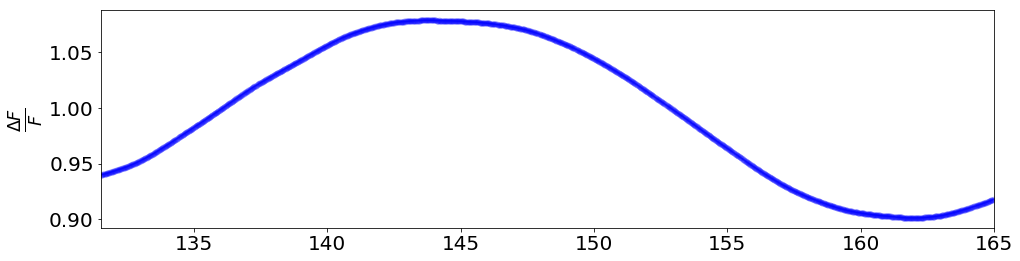

In [7]:
%matplotlib inline
qt.plot_lc(Q1_coo.data[np.isnan(Q1_coo.data.mautocorrcoef)].index[0],filepath=Q1_fits_path)

In [51]:
Q1_coo.data = Q1_coo.data.fillna(0).isna().any()

In [47]:
np.__version__

'1.11.3'